# Pre Req
Clone to SI codes
Download Pretrained Weights

In [1]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 121 (delta 68), reused 32 (delta 9), pack-reused 0
Receiving objects: 100% (121/121), 138.91 KiB | 17.36 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
# download Pretrained Model
!gdown 1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA

Downloading...
From: https://drive.google.com/uc?id=1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA
To: /content/efficientnetv2_s_cifar100_finetuned.pth
100% 82.1M/82.1M [00:00<00:00, 103MB/s] 


# Import libraries

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Subset, DataLoader
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data.sampler import SubsetRandomSampler

from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

# Q2

**Load Model**

In [2]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)


transform = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(260),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your pre-trained model weights
model.load_state_dict(torch.load('efficientnetv2_s_cifar100_finetuned.pth'))


model.eval()
model.cuda()

print("Model Loaded")

Model Loaded


**Load Subset of CIFA100**

In [3]:
# Load the CIFAR-100 dataset and create a balanced subset
transform = transforms.Compose([transforms.ToTensor()])

cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_train])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.5
subset_fraction_test = 1

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train.classes)))
class_indices_test = list(range(len(cifar100_test.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")

Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 25000
Balanced Test set size: 10000


**Count Number of layer**

In [4]:
# Counter Num Layer
counter = 0
for idx, layer in enumerate(model.features):
  counter +=1
print(f"Number of layer is : {counter}")

Number of layer is : 8


**Attach Hooks to each layer**

In [5]:
# Prepare storage for outputs and labels
features_per_layer = [[] for _ in range(len(model.features))]
labels_list = []

# Function to attach hooks
def get_layer_outputs(layer_idx):
    def hook(module, input, output):
        features_per_layer[layer_idx].append(output.detach())
    return hook

# Attach hooks to each layer
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_layer_outputs(idx))

## Train data
plot SI vs Layer for train data (50%)

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)

100%|██████████| 98/98 [00:17<00:00,  5.57it/s]


In [9]:
si_layer_train =[]
for features in features_per_layer:
  instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
  si = instance_disturbance.si()
  # num_ones = torch.sum(si_data == 1).item()
  # total_elements = si_data.numel()
  # ratio_ones = num_ones / total_elements
  si_layer_train.append(si)

Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 19563.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 19308.37it/s]


Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 15270.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 14055.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 18904.38it/s]


Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 18807.09it/s]


Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 19247.51it/s]


Data has been normalized


Calculating SI: 100%|██████████| 25000/25000 [00:01<00:00, 18910.10it/s]


In [10]:
si_layer_train

[0.1122, 0.08148, 0.257, 0.391, 0.4246, 0.50996, 0.65252, 0.67892]

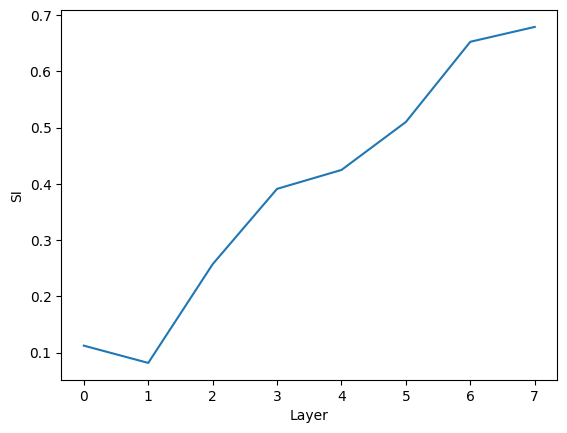

In [11]:
# plot si vs layer for Train
plt.plot(si_layer_train)
plt.xlabel('Layer')
plt.ylabel('SI')
plt.show()

## Test data
plot SI vs Layer for test data (60%)

**** Restart Kernel and run again for Test Section

In [6]:
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)


100%|██████████| 40/40 [00:11<00:00,  3.57it/s]


In [7]:
si_layer_test =[]
for features in features_per_layer:
  instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
  si = instance_disturbance.si()
  si_layer_test.append(si)

Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 12356.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 19914.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 19259.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 19534.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 19013.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 18810.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 18063.46it/s]


Data has been normalized


Calculating SI: 100%|██████████| 10000/10000 [00:00<00:00, 18768.76it/s]


In [8]:
si_layer_test

[0.0861, 0.0608, 0.2005, 0.3197, 0.3364, 0.3854, 0.4372, 0.4371]

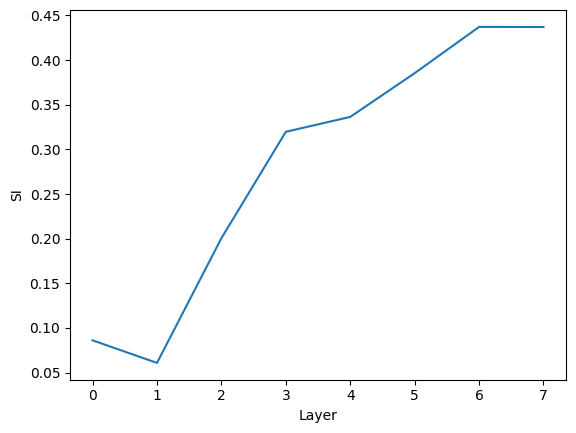

In [9]:
# plot si vs layer for Train
plt.plot(si_layer_test)
plt.xlabel('Layer')
plt.ylabel('SI')
plt.show()